# 1. Assume that we only want to use the input at time step $t'$ to predict the output at time step $t\gt t'$. What are the best values for the reset and update gates for each time step?

- rest gate value can be any value
- update gate value = 1

# 2. Adjust the hyperparameters and analyze their influence on running time, perplexity, and the output sequence.

In [1]:
import sys
import torch.nn as nn
import torch
import warnings
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
warnings.filterwarnings("ignore")
from sklearn.model_selection import ParameterGrid

class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)
        
def stat_val(model, data):
    ppls = []
    for batch in iter(data.get_dataloader(False)):
        ppls.append(model.validation_step(batch, plot_flag=False).detach().numpy())
    return np.exp(np.mean(ppls))

def experient(data_class=d2l.TimeMachine, num_steps=32, num_hiddens=32, lr=1):
    data = data_class(batch_size=1024, num_steps=num_steps)
    gru = GRU(num_inputs=len(data.vocab), num_hiddens=num_hiddens)
    model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=lr)
    trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1) #, num_gpus=1
    trainer.fit(model, data)
    return stat_val(model, data)

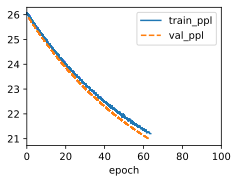

In [ ]:
param_grid = {'num_steps':[8, 16, 32, 64, 128],
              'num_hiddens':[8, 16, 32, 64, 128],
              'lr':[0.01,0.1,1,10]}
param_grid_obj = ParameterGrid(param_grid)
ppls = []
for params in param_grid_obj:
    ppl = experient(**params)
    ppls.append(ppl)
    print(params, ppl)

# 3. Compare runtime, perplexity, and the output strings for rnn.RNN and rnn.GRU implementations with each other.

# 4. What happens if you implement only parts of a GRU, e.g., with only a reset gate or only an update gate?

In [ ]:
class ResetGRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        # self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state
        
    def forward(self, inputs, H=None):
        if H is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
        outputs = []
        for X in inputs:
            # Z = torch.sigmoid(torch.matmul(X, self.W_xz) +
            #                 torch.matmul(H, self.W_hz) + self.b_z)
            R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                            torch.matmul(H, self.W_hr) + self.b_r)
            H_tilde = torch.tanh(torch.matmul(X, self.W_xh) +
                               torch.matmul(R * H, self.W_hh) + self.b_h)
            H = Z * H + (1 - Z) * H_tilde
            H = H_tilde
            outputs.append(H)
        return outputs, H
    
class UpdateGRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        # self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state
        
    def forward(self, inputs, H=None):
        if H is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
        outputs = []
        for X in inputs:
            Z = torch.sigmoid(torch.matmul(X, self.W_xz) +
                            torch.matmul(H, self.W_hz) + self.b_z)
            # R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                            # torch.matmul(H, self.W_hr) + self.b_r)
            H_tilde = torch.tanh(torch.matmul(X, self.W_xh) +
                               torch.matmul(H, self.W_hh) + self.b_h)
            H = Z * H + (1 - Z) * H_tilde
            H = H_tilde
            outputs.append(H)
        return outputs, H

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)